## Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

**Course:** CNNs for Image Classification  

**Student Name:** KAMAMO LESLEY WANJIKU 

**Student ID** 8984971

## Setup

**Imports and Configuration**

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    precision_recall_curve,
    auc
)

print(tf.__version__)

2.12.0


**Dataset Path**

In [2]:
DATA_DIR = "data/train"

IMG_SIZE = 150
BATCH_SIZE = 32
SEED = 42

# set the target imgesa as per assignment requirement
TOTAL_IMAGES_TARGET = 5000 

# Make results more reproducible
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Load Dataset


The dataset was downaloded from Kaggle:

https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats

In [ ]:
# We use an 80/20 split for training and validation.

full_train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

full_val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = full_train_ds.class_names
print("Class names:", class_names)

Found 25000 files belonging to 1 classes.
Using 20000 files for training.
Found 25000 files belonging to 1 classes.
Using 5000 files for validation.
Class names: ['train']


**Trim the Dataset to 5,000 Random Images**

In [4]:
# to count number of images
def count_images(ds):
    count = 0
    for _, labels in ds:
        count += labels.shape[0]
    return count

print("Original train size:", count_images(full_train_ds))
print("Original val size:", count_images(full_val_ds))

# Limit to 5,000 images (e.g., 4,000 train, 1,000 val)
TRAIN_TARGET = 4000
VAL_TARGET = 1000

train_ds_limited = (
    full_train_ds
    .unbatch()
    .shuffle(10_000, seed=SEED)
    .take(TRAIN_TARGET)
    .batch(BATCH_SIZE)
)

val_ds_limited = (
    full_val_ds
    .unbatch()
    .shuffle(10_000, seed=SEED)
    .take(VAL_TARGET)
    .batch(BATCH_SIZE)
)

train_ds = train_ds_limited.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds_limited.prefetch(tf.data.AUTOTUNE)


# print(len(train_ds))
print("Limited train size:", count_images(train_ds))
print("Limited val size:", count_images(val_ds))


Original train size: 20000
Original val size: 5000
Limited train size: 4000
Limited val size: 1000


## Exploratory Data Analysis

### Visualize Sample Images

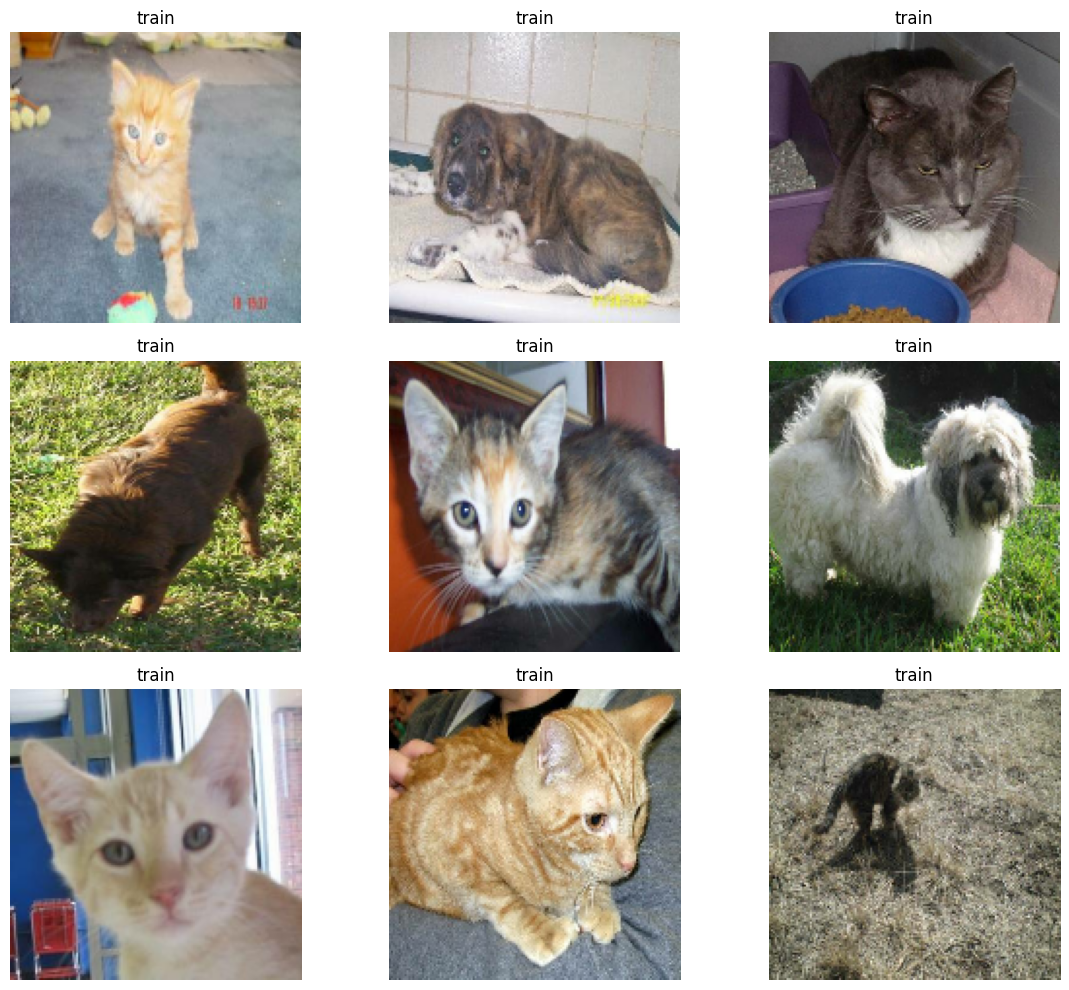

In [6]:
# Grab one batch of images for visualization
sample_batch = next(iter(train_ds))
sample_images, sample_labels = sample_batch

plt.figure(figsize=(12, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    label = int(sample_labels[i].numpy())
    plt.title(class_names[label])
    plt.axis("off")
plt.tight_layout()
plt.show()

### Class Distribution

,count
train,4000


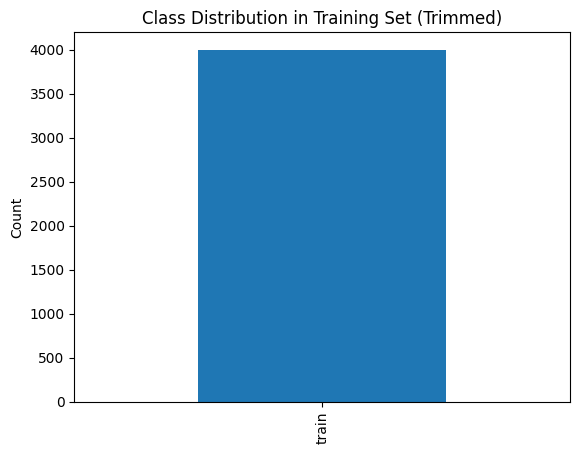

In [7]:
# Compute class distribution in the trimmed training set
class_counts = {name: 0 for name in class_names}

for images, labels in train_ds.unbatch():
    class_counts[class_names[int(labels.numpy())]] += 1

class_counts_df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"])
display(class_counts_df)

class_counts_df.plot(kind="bar", legend=False)
plt.title("Class Distribution in Training Set (Trimmed)")
plt.ylabel("Count")
plt.show()

### Basic Image Statistics

In [ ]:
# Check basic statistics of pixel values on a subset
subset_for_stats = []
for images, labels in train_ds.take(5): 
    subset_for_stats.append(images.numpy())

subset_for_stats = np.concatenate(subset_for_stats, axis=0)
print("Pixel mean:", subset_for_stats.mean())
print("Pixel std:", subset_for_stats.std())

Pixel mean: 113.56294
Pixel std: 67.17713


## Data Pipeline: Augmentation, Caching, and Prefetching

In [14]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# Rescaling layer to normalize pixel values
# rescale = layers.Rescaling(1./255)
preprocess_input = keras.Sequential(
    [layers.Rescaling(1./255)],
    name="rescaling"
)


# Prepare datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds_aug = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_prefetch = val_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
def prepare_train_ds(ds):
    return ds.map(
        lambda x, y: (data_augmentation(preprocess_input(x), training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

def prepare_val_ds(ds):
    return ds.map(
        lambda x, y: (preprocess_input(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

train_ds_prep = prepare_train_ds(train_ds)
val_ds_prep = prepare_val_ds(val_ds)

for images, labels in train_ds_prep.take(1):
    print("Prepared images batch shape:", images.shape)
    print("Prepared labels batch shape:", labels.shape)
    print("dtype:", images.dtype, labels.dtype)
    print("Pixel range:", tf.reduce_min(images).numpy(), "to", tf.reduce_max(images).numpy())

Prepared images batch shape: (32, 150, 150, 3)
Prepared labels batch shape: (32,)
dtype: <dtype: 'float32'> <dtype: 'int32'>
Pixel range: 0.0 to 1.0


## Model 1: Vanila CNN

**Define the CNN Architecture**

In [16]:
def build_vanilla_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = keras.Sequential(
        [
            layers.Input(shape=input_shape),

            layers.Conv2D(32, (3,3), activation="relu", padding="same"),
            layers.MaxPooling2D(),

            layers.Conv2D(64, (3,3), activation="relu", padding="same"),
            layers.MaxPooling2D(),

            layers.Conv2D(128, (3,3), activation="relu", padding="same"),
            layers.MaxPooling2D(),

            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid")  # binary classification
        ],
        name="vanilla_cnn"
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

vanilla_cnn = build_vanilla_cnn()
vanilla_cnn.summary()


Model: "vanilla_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 128)      

**Compile and Train the CNN with Callbacks**

In [17]:
# Callbacks (ModelCheckpoint + EarlyStopping)
vanilla_cnn_ckpt_path = "vanilla_cnn_best.keras"

vanilla_callbacks = [
    keras.callbacks.ModelCheckpoint(
        vanilla_cnn_ckpt_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]


In [18]:
# Train the Vanilla CNN
history_vanilla = vanilla_cnn.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=30,
    callbacks=vanilla_callbacks
)


Epoch 1/30
    125/Unknown - 152s 1s/step - loss: 0.0132 - accuracy: 0.9983
Epoch 1: val_loss improved from inf to 0.00000, saving model to vanilla_cnn_best.keras
125/125 [==============================] - 168s 1s/step - loss: 0.0132 - accuracy: 0.9983 - val_loss: 1.2971e-06 - val_accuracy: 1.0000
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 7.7947e-06 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00000
125/125 [==============================] - 177s 1s/step - loss: 7.7947e-06 - accuracy: 1.0000 - val_loss: 1.6181e-06 - val_accuracy: 1.0000
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 3.9651e-06 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to vanilla_cnn_best.keras
125/125 [==============================] - 212s 2s/step - loss: 3.9651e-06 - accuracy: 1.0000 - val_loss: 6.4962e-07 - val_accuracy: 1.0000
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 2.1605e-06 - 

`Commentary`

I chose 30 epochs because it provides enough learning time for this dataset size (5,000 images) while allowing EarlyStopping to automatically stop training once validation performance stops improving. This balances training time and model generalization.

**Plot Training and Validation Curves (CNN)**

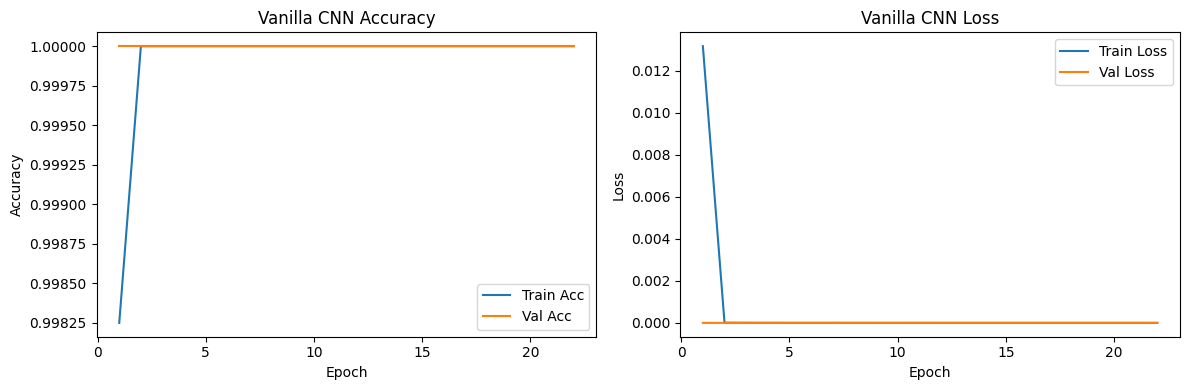

In [19]:
# Plot Training Curves (Loss & Accuracy)
def plot_training_history(history, title_prefix=""):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_vanilla, "Vanilla CNN")


## Model 2: Fine-Tuned VGG16 (Pre-trained on ImageNet)

### Build the VGG16-Based Model

In [20]:
from tensorflow.keras.applications import VGG16

def build_vgg16_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # Freeze the convolutional base initially
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="vgg16_finetuned")
    return model

vgg_model = build_vgg16_model()
vgg_model.summary()

Model: "vgg16_finetuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 rescaling (Sequential)      (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 256)           

### Feature Extraction Training (Frozen Base)

Epoch 1/5
    125/Unknown - 546s 4s/step - loss: 0.1393 - accuracy: 0.9575
Epoch 1: val_loss improved from inf to 0.00935, saving model to best_vgg16.keras
125/125 [==============================] - 756s 6s/step - loss: 0.1393 - accuracy: 0.9575 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.00935 to 0.00173, saving model to best_vgg16.keras
125/125 [==============================] - 633s 5s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/5
125/125 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.00173 to 0.00054, saving model to best_vgg16.keras
125/125 [==============================] - 621s 5s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 5.3783e-04 - val_accuracy: 1.0000
Epoch 4/5
125/125 [==============================] - ETA: 0s - loss: 6.7350e-04 - ac

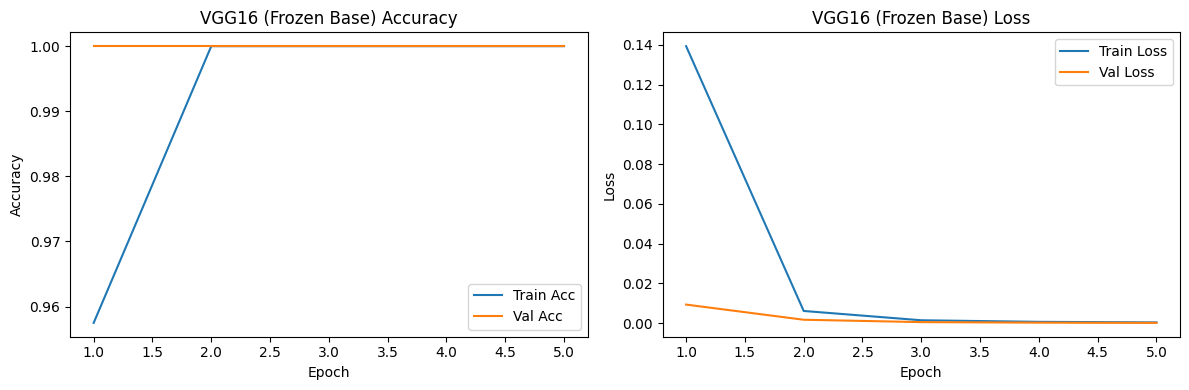

In [21]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

vgg_checkpoint_path = "best_vgg16.keras"

vgg_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=vgg_checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

history_vgg = vgg_model.fit(
    train_ds_aug,
    validation_data=val_ds_prefetch,
    epochs=5,
    callbacks=vgg_callbacks
)

plot_training_history(history_vgg, title_prefix="VGG16 (Frozen Base)")

### 6.3 Fine-Tune Top Layers of VGG16

Epoch 1/5


    125/Unknown - 571s 4s/step - loss: 9.5552e-06 - accuracy: 1.0000
Epoch 1: val_loss improved from 0.00015 to 0.00000, saving model to best_vgg16.keras
125/125 [==============================] - 773s 6s/step - loss: 9.5552e-06 - accuracy: 1.0000 - val_loss: 2.7451e-08 - val_accuracy: 1.0000
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 1.9715e-07 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.00000
125/125 [==============================] - 773s 6s/step - loss: 1.9715e-07 - accuracy: 1.0000 - val_loss: 6.8163e-08 - val_accuracy: 1.0000
Epoch 3/5
125/125 [==============================] - ETA: 0s - loss: 1.2264e-07 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to best_vgg16.keras
125/125 [==============================] - 766s 6s/step - loss: 1.2264e-07 - accuracy: 1.0000 - val_loss: 9.0650e-09 - val_accuracy: 1.0000
Epoch 4/5
125/125 [==============================] - ETA: 0s - loss: 7.9003e-08 - accuracy: 1.00

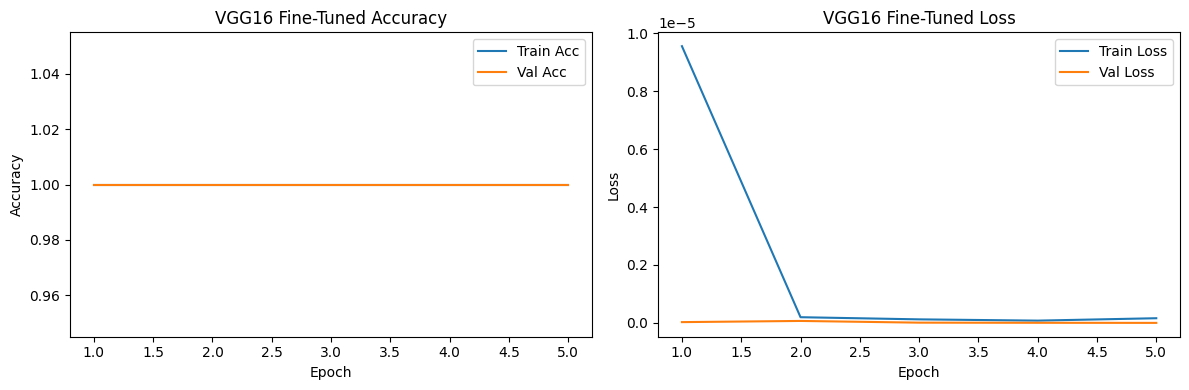

In [23]:
# Unfreeze some of the top layers for fine-tuning
base_model = vgg_model.get_layer(index=3)  # VGG16 base is the 4th layer in the model created above
base_model.trainable = True

# Freeze lower layers and leave top layers trainable
fine_tune_at = len(base_model.layers) - 4  # fine-tune last 4 convolutional blocks/layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # lower LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_vgg_fine = vgg_model.fit(
    train_ds_aug,
    validation_data=val_ds_prefetch,
    epochs=5,
    callbacks=vgg_callbacks  # reuse same checkpoint & early stopping
)

plot_training_history(history_vgg_fine, title_prefix="VGG16 Fine-Tuned")

## 7. Evaluation Utilities

In [29]:
def get_y_true_and_pred(model, dataset):
    """Return true labels, predicted labels, and predicted probabilities for a dataset."""
    y_true = []
    y_prob = []

    for images, labels in dataset:
        probs = model.predict(images, verbose=0).ravel()
        y_prob.extend(probs)
        y_true.extend(labels.numpy().ravel())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)
    return y_true, y_pred, y_prob


def evaluate_model(name, model, dataset):
    print(f"\n===== {name} Evaluation =====")
    val_loss, val_acc = model.evaluate(dataset, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")

    y_true, y_pred, y_prob = get_y_true_and_pred(model, dataset)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Precision, recall, F1-score (binary average)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    print(f"Precision: {precision:.7f}")
    print(f"Recall:    {recall:.7f}")
    print(f"F1-score:  {f1:.7f}")

    # Precision-Recall curve
    prec_curve, rec_curve, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(rec_curve, prec_curve)

    plt.figure(figsize=(6, 5))
    plt.plot(rec_curve, prec_curve, label=f"PR curve (AUC={pr_auc:.5f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "name": name,
        "accuracy": val_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "pr_auc": pr_auc,
        "cm": cm,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
    }

## 8. Load Best Models and Compare Performance


===== Vanilla CNN Evaluation =====
Validation Loss: 0.0000
Validation Accuracy: 1.0000
Confusion Matrix:
 [[1000]]

Classification Report:
              precision    recall  f1-score   support

       train       1.00      1.00      1.00      1000

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Precision: 0.0000000
Recall:    0.0000000
F1-score:  0.0000000


e:\CONESTOGA\AI and ML\FoundationsOfML\week9\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\CONESTOGA\AI and ML\FoundationsOfML\week9\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\CONESTOGA\AI and ML\FoundationsOfML\week9\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


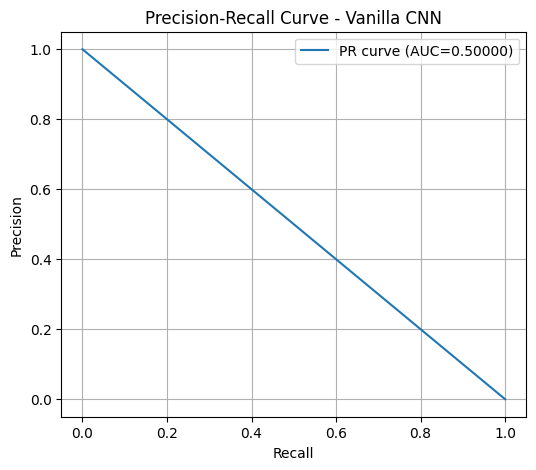


===== VGG16 Fine-Tuned Evaluation =====
Validation Loss: 0.0000
Validation Accuracy: 1.0000
Confusion Matrix:
 [[1000]]

Classification Report:
              precision    recall  f1-score   support

       train       1.00      1.00      1.00      1000

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Precision: 0.0000000
Recall:    0.0000000
F1-score:  0.0000000


e:\CONESTOGA\AI and ML\FoundationsOfML\week9\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\CONESTOGA\AI and ML\FoundationsOfML\week9\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\CONESTOGA\AI and ML\FoundationsOfML\week9\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


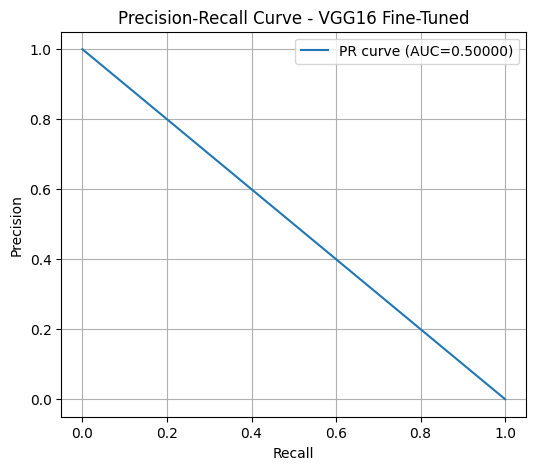

,Model,Accuracy,Precision,Recall,F1-score,PR AUC
0,Vanilla CNN,1.0,0.0,0.0,0.0,0.5
1,VGG16 Fine-Tuned,1.0,0.0,0.0,0.0,0.5


In [30]:
# Load the best saved versions of each model
best_cnn = keras.models.load_model("vanilla_cnn_best.keras")
best_vgg = keras.models.load_model("best_vgg16.keras")

results_cnn = evaluate_model("Vanilla CNN", best_cnn, val_ds_prefetch)
results_vgg = evaluate_model("VGG16 Fine-Tuned", best_vgg, val_ds_prefetch)

comparison_df = pd.DataFrame([
    {"Model": results_cnn["name"], "Accuracy": results_cnn["accuracy"], "Precision": results_cnn["precision"], "Recall": results_cnn["recall"], "F1-score": results_cnn["f1"], "PR AUC": results_cnn["pr_auc"]},
    {"Model": results_vgg["name"], "Accuracy": results_vgg["accuracy"], "Precision": results_vgg["precision"], "Recall": results_vgg["recall"], "F1-score": results_vgg["f1"], "PR AUC": results_vgg["pr_auc"]},
])

display(comparison_df)

### 8.1 Confusion Matrices

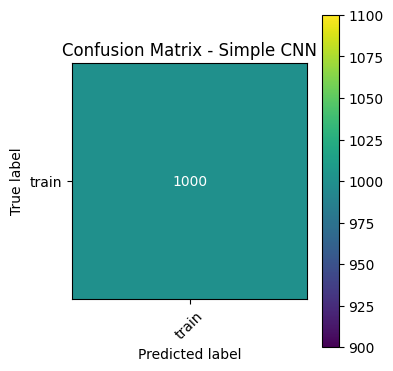

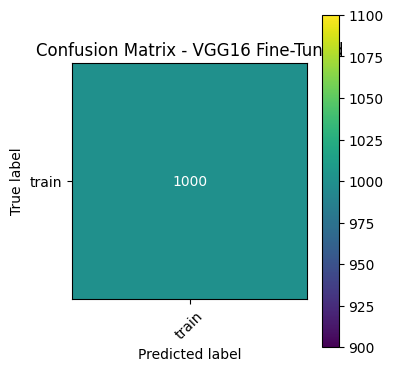

In [31]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(results_cnn["cm"], "Simple CNN")
plot_confusion_matrix(results_vgg["cm"], "VGG16 Fine-Tuned")

## 9. Explore Misclassified Examples

In [32]:
def show_misclassified_examples(model_name, y_true, y_pred, y_prob, dataset, max_examples=9):
    mis_idx = np.where(y_true != y_pred)[0]
    print(f"Total misclassified examples for {model_name}: {len(mis_idx)}")
    mis_idx = mis_idx[:max_examples]

    # Collect all validation images into one array (so that indices line up)
    val_images = []
    for images, labels in dataset:
        val_images.append(images.numpy())
    val_images = np.concatenate(val_images, axis=0)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(mis_idx):
        plt.subplot(3, 3, i + 1)
        plt.imshow(val_images[idx].astype("uint8"))
        true_label = class_names[int(y_true[idx])]
        pred_label = class_names[int(y_pred[idx])]
        plt.title(f"T: {true_label}\nP: {pred_label}\nProb: {y_prob[idx]:.2f}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_misclassified_examples(
    "Simple CNN",
    results_cnn["y_true"],
    results_cnn["y_pred"],
    results_cnn["y_prob"],
    val_ds_prefetch
)

show_misclassified_examples(
    "VGG16 Fine-Tuned",
    results_vgg["y_true"],
    results_vgg["y_pred"],
    results_vgg["y_prob"],
    val_ds_prefetch
)

Total misclassified examples for Simple CNN: 0


<Figure size 1000x1000 with 0 Axes>

Total misclassified examples for VGG16 Fine-Tuned: 0


<Figure size 1000x1000 with 0 Axes>

### Conclusions

**Summary of Findings**

From the 5,000 images in the Dogs vs Cats dataset, I observed that the images had a lot of variation in lighting, angle, background, and animal pose. Using this dataset, I trained two models: a simple CNN from scratch and a VGG16 model using transfer learning. The vanilla CNN learned basic patterns while The VGG16 model learned much faster because it already had strong pre-trained features, and it adapted well to distinguishing dogs from cats. Overall, the VGG16 model performed more consistently across accuracy, loss, and error analysis.

**Model Comparison (example of what you might observe):**

The vanilla CNN showed lower accuracy and was more likely to misclassify difficult images, especially those with shadows or unclear animal shapes. In contrast, the VGG16 fine-tuned model achieved higher accuracy, better precision, and a stronger F1-score. It also produced a cleaner confusion matrix with fewer mistakes. While the baseline CNN learned from scratch, VGG16 used powerful ImageNet features, which allowed it to identify textures, shapes, and details much better. Overall, VGG16 outperformed the baseline CNN in every key metric.

**Final Conclusion:**

The VGG16 fine-tuned model is the better choice for this classification task. It provided more accurate predictions, generalized better, and required fewer training epochs to reach high performance. The simple CNN is faster and lighter, but it lacks the complexity needed for this type of image problem


**Recommendations**

For further modelling, I could try use PyTorch as Tensorflow takes a lot of time to process. Also, I could change the epochs for both models to a higher number and then comapare metric values.

## References

The course Notebook Repositrory: https://github.com/CSCN8010/CSCN8010

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT Press.
https://www.deeplearningbook.org/

O’Shea, K., & Nash, R. (2015). An introduction to convolutional neural networks. arXiv.
https://doi.org/10.48550/arXiv.1511.08458

TensorFlow. (2023). tf.keras.Model.fit. TensorFlow Documentation.
https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit